# Model inference on open-source data

This notebook is a simple example of how to load a trained model and make predictions on a publicly available dataset. The model we're working with was trained using the scripts in notebook [4_backward_model_training.ipynb](4_backward_model_training.ipynb).

## Load data
For the purpose of inference we download a small open-source dataset unrelated with any data we've used so far. It is a [MACE](https://leopard.tu-braunschweig.de/receive/dbbs_mods_00076224) dataset with compounds not included in the NIST17 dataset. Some of them are in NIST20 though.

In [21]:
import sys
sys.path.append('..')

In [22]:
MACE_DIR = "../data/mace"
CHECKPOINT_DIR = "../../checkpoints/finetune/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/checkpoint-147476"
TOKENIZER_PATH = "../tokenizer/tokenizer_mf10M.model"

In [23]:
# download MACE data
! cd {MACE_DIR} && wget https://leopard.tu-braunschweig.de/servlets/MCRFileNodeServlet/dbbs_derivate_00054495/MACE_r05.mace

mace_path = f"{MACE_DIR}/MACE_r05.mace"

--2024-08-31 20:34:14--  https://leopard.tu-braunschweig.de/servlets/MCRFileNodeServlet/dbbs_derivate_00054495/MACE_r05.mace
Resolving leopard.tu-braunschweig.de (leopard.tu-braunschweig.de)... 193.174.240.199
Connecting to leopard.tu-braunschweig.de (leopard.tu-braunschweig.de)|193.174.240.199|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified
Saving to: 'MACE_r05.mace.1'

MACE_r05.mace.1         [ <=>                ] 344.82K  --.-KB/s    in 0.09s   

2024-08-31 20:34:15 (3.82 MB/s) - 'MACE_r05.mace.1' saved [353094]



In [137]:
# the format of the MACE data is a bit inconsistent (because of the open-source nature), so we wrote our own .msp reader for this dataset 
import requests
import pandas as pd
from rich import progress
import re
from pathlib import Path

from utils.spectra_process_utils import remove_stereochemistry_and_canonicalize


def get_smiles_from_inchikey(inchikey):
    r = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchikey}/property/CanonicalSMILES/JSON').json()    
    return r['PropertyTable']['Properties'][0]['CanonicalSMILES']

def parse_mz_intensity(f, num_peaks):
    mz = []
    intensity = []
    line = next(f)
    while line.strip() != "":
        line_peaks = [peak.strip().split(" ") for peak in re.split(";|:", line.strip())]
        for peak in line_peaks:
            if peak == ['']:
                continue
            peak = [peak_ for peak_ in peak if peak_ != '']
            mz_, intensity_ = peak
            mz.append(float(mz_))
            intensity.append(float(intensity_))
        try:
            line = next(f)
        except StopIteration:
            break
    if num_peaks != len(mz):
        num_peaks = len(mz)
    
    # sort peaks
    mz, intensity = zip(*sorted(zip(mz, intensity), key=lambda x: x[0]))

    return list(mz), list(intensity), num_peaks


def read_mace_msp(filename):
    """Iterate over MSP spectral library file and return spectra as dicts."""
    spectrum = {}
    mz = []
    intensity = []

    with progress.open(filename, "rt") as f:
        for line in f:
            # `Name: ` is the first line of a new entry in the file
            if line.startswith("Name: "):
                if spectrum:
                    # Finalize and yield previous spectrum
                    yield spectrum

                    # Define new spectrum
                    spectrum = {}
                    mz = []
                    intensity = []

                # Extract everything after `Name: `
                spectrum["Name"] = line.split(":")[1].strip()


            elif line.startswith("Comments: "):
                # Parse all comment items as metadata
                metadata_string = "".join(line.split(":")[1:]).strip()
                metadata = [i.split("=") for i in metadata_string.split(" ")]
                
                for item in metadata:
                    item = [i.strip() for i in item]
                    if item[0] == "Smiles":
                        spectrum["smiles"] = "".join(item[1:]) 
                    elif len(item) == 2:
                        spectrum[item[0]] = item[1]

            elif line.startswith("InChIKey: "):
                spectrum["InChIKey"] = line.split(":")[1].strip()
                
            elif line.startswith("Num Peaks:") or line.startswith("Num peaks:"):
                num_peaks = int(line.split(":")[1].strip())
                mz, intensity, num_peaks_  = parse_mz_intensity(f, num_peaks)   

                spectrum["num_peaks"] = num_peaks_
                spectrum["mz"] = mz
                spectrum["intensity"] = intensity 
                
    # Final spectrum
    yield spectrum

def remove_corrupted_spectra(spectra):
    clean_spectra = []
    for s in spectra:
        if not s.get("mz", False) or not s.get("intensity", False):
            continue
        
        s["smiles"] = remove_stereochemistry_and_canonicalize(s["smiles"])
        if not s.get("smiles", False) or not s["smiles"]:
            try:
                smi = get_smiles_from_inchikey(s["InChIKey"])
                s["smiles"] = remove_stereochemistry_and_canonicalize(smi)
                if not s["smiles"]:
                    continue
            except:
                continue
        clean_spectra.append(s) 
    return clean_spectra


def save_mace_jsonl(spectra, out_path):
    mzs = [s["mz"] for s in spectra]
    intensities = [s["intensity"] for s in spectra]
    canon_smiless = [s["smiles"] for s in spectra]
    df = pd.DataFrame({"mz": mzs, "intensity": intensities, "smiles": canon_smiless})
    df.to_json(out_path, orient="records", lines=True)

In [138]:
mace_jsonl_path = f"{Path(mace_path).with_suffix('.jsonl')}"

spectra = list(read_mace_msp(mace_path))
clean_spectra = remove_corrupted_spectra(spectra)
save_mace_jsonl(clean_spectra, mace_jsonl_path)

print(f"Extracted: {len(clean_spectra)} spectra from MACE database")

Output()

[10:34:43] SMILES Parse Error: syntax error while parsing: OC1OC[C@@H](C)CCC/C(C)C\CC[C@H]1C;
[10:34:43] SMILES Parse Error: Failed parsing SMILES 'OC1OC[C@@H](C)CCC/C(C)C\CC[C@H]1C;' for input: 'OC1OC[C@@H](C)CCC/C(C)C\CC[C@H]1C;'


Smiles OC1OC[C@@H](C)CCC/C(C)C\CC[C@H]1C; is not valid.


[10:34:44] SMILES Parse Error: syntax error while parsing: OC1OC[C@H](C)CCC/C(C)C/CC[C@H]1C;
[10:34:44] SMILES Parse Error: Failed parsing SMILES 'OC1OC[C@H](C)CCC/C(C)C/CC[C@H]1C;' for input: 'OC1OC[C@H](C)CCC/C(C)C/CC[C@H]1C;'


Smiles OC1OC[C@H](C)CCC/C(C)C/CC[C@H]1C; is not valid.


[10:34:44] SMILES Parse Error: syntax error while parsing: OC1OC[C@H](C)CCC/C(C)C\CC[C@H]1C;
[10:34:44] SMILES Parse Error: Failed parsing SMILES 'OC1OC[C@H](C)CCC/C(C)C\CC[C@H]1C;' for input: 'OC1OC[C@H](C)CCC/C(C)C\CC[C@H]1C;'


Smiles OC1OC[C@H](C)CCC/C(C)C\CC[C@H]1C; is not valid.


[10:34:44] SMILES Parse Error: extra open parentheses for input: 'OC(C(NC(CCC(C)CO)COC(CCCCC)O)OC'


Smiles OC(C(NC(CCC(C)CO)COC(CCCCC)O)OC is not valid.


Extracted: 248 spectra from MACE database

## Generate predictions

Now we have the MACE dataset prepared the same way as all our NIST splits and can continue to predicting molecules from spectra.

To generate predictions we need to specify a configuration file and a path to the trained model. The configuration file for MACE dataset is provided in the `config` directory as [predict_mace.yaml](../configs/predict_mace.yaml). 

The script [predict.py](../predict.py) is used to generate predictions. It takes a `jsonl` file with `mz` and `intensity` fields as inputs. It outputs a `jsonl` file where each line is a `json` with keys being the generated SMILES strings and their values are candidates' probabilities generated by our model. We use these probabilities to sort candidates.

Statistics and all metadata about the run are stored in `log_file.yaml` in the same directory as the predictions.

Running `predict.py` could look like this:

```bash
CUDA_VISIBLE_DEVICES=0 python ../predict.py --checkpoint ../checkpoints/finetune/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/checkpoint-147476 \
                                            --output-folder predictions \
                                            --config-file configs/predict_mace.yaml
```

## Evaluate predictions
Evaluation of predictions is done with the [evaluate_predictions.py](../evaluate_predictions.py) script. It takes a path to the predictions file, a path to the ground truth file and a path to a [config file](../configs/evaluate_mace.yaml) as input and appends all the evaluation metrics to the corresponding `log_file.yaml`. The script also generates several plots and saves them in the same directory as the predictions.

**Note**: Be aware of filtering mechanism in the datapipeline - we use both m/z values and SMILES strings for filtering and perform filtering during both generation and evaluation stages. If you have your spectra and labels in two separate files you easily end up with different lengths of predictions-labels lists or paired predictions with wrong labels. Also be sure to have the same filtering criteria specified in config files during prediction and evaluation. **In other words**: have your labels ("smiles") and spectra ("mz", "intensity") in the same file when evaluating a test file. Also check the values of `max_num_peaks`, `max_mz`, `max_mol_repr_len` and `mol_repr` in the config files. They should be the same for both prediction and evaluation.

Running `evaluate_predictions.py` could look like this:

```bash
python evaluate_predictions.py --predictions-path predictions/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/MACE/1725179758_all_full_beam10/predictions.jsonl \
                               --labels-path data/mace/MACE_r05.jsonl \
                               --config-file configs/evaluate_mace.yaml
```

As you may notice from the `log_file`, performance on this dataset is significantly lower than on the NIST datasets. We will explore the reasons later during the analysis and we'll take a look at the predictions in context with the standard database search.


## Comparison with database search
To find out how is the model doing against baseline you can also run the evluation in comparison with a standard database search in the de novo scenario. As a reference library we use the NIST train set with 232 025 experimentally measured spectra, and query library is the MACE dataset with 244 spectra. 

For this scenario to work we need to precompute the highest cosine similarity of the query spectra within the reference library and their respective SMILES (fingerprint) similarity. This fingerprint similarity is then compared to the similarity of our model's candidates.

First we check whether there is an overlap between the MACE dataset and our NIST20 train split. 

In [142]:
# load NIST train SMILES
nist_train_smi_path = "../data/nist/train.smi"
nist_train_smiles = [line.strip() for line in open(nist_train_smi_path).readlines()]

In [153]:
# check how many MACE spectra are in NIST train
from utils.eval_utils import load_labels_to_datapipe

labels, _ = load_labels_to_datapipe(Path(mace_jsonl_path))
labels = list(labels)

set_nist_train = set(nist_train_smiles)
set_mace = set(labels)
overlap = set_nist_train.intersection(set_mace) # 20/248 molecules are in the reference database => its easier for our competitor 

print(f"{len(set_mace)}/{len(labels)} molecules are unique, there is {len(overlap)} unique overlapping molecules")

/home/xhajek9/miniconda3/envs/BARTtrainH100/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


178/244 molecules are unique, there is 20 unique overlapping molecules

We see that there is certain overlap between the MACE dataset and the reference library but we will leave it there so we can further analyze it in the end of this notebook.

### Precompute similarity index for MACE

```bash
SPLIT_NAME=all
FP_TYPE=morgan
SIMIL_FUN=tanimoto

python ../precompute_db_index.py \
           --reference data/nist/train.jsonl \
           --query data/mace/MACE_r05.jsonl \
           --outfile data/mace/MACE_r05_with_db_index.jsonl \
           --num_processes 8 \
           --fingerprint_type ${FP_TYPE} \
           --simil_function ${SIMIL_FUN}
```

### Evaluate including database search comparison
For this you have to set `do_db_search` in [evaluate_mace.yaml](../configs/evaluate_mace.yaml) to `True` and change the labels to the ones enriched with db index.

Example:
```bash
python evaluate_predictions.py --predictions-path predictions/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/MACE/1725179758_all_full_beam10/predictions.jsonl \
                               --labels-path data/mace/MACE_r05_with_db_index.jsonl \
                               --config-file configs/evaluate_mace.yaml
```

The results of the 

-----------------------------------------------
# Playground
## Visualize predictions
To see what the model's predictions look like we prepared a little visualization script. You can notice that the MACE molecules often contain mainly long sequences of carbons and hydrogens which are very hard to recunstruct after it's shattered into pieces by the MS. Also the atom variability is much lower than in the NIST datasets.

In [155]:
import json
from rdkit import Chem, DataStructs

# load labels and predictions
predictions_path = "../predictions/fearless-wildflower-490_rassp1_neims1_224kPretrain_148k/MACE/1725179758_all_full_beam10/predictions.jsonl"
labels_path = mace_jsonl_path


labels, _ = load_labels_to_datapipe(Path(labels_path))
labels = list(labels)
str_predictions = open(predictions_path).readlines()
dict_predictions = [json.loads(p) for p in str_predictions]
sorted_predictions = [sorted([k for k, _ in sorted(pred.items(), key=lambda x: x[1])]) for pred in dict_predictions]


##################

GT smiles: CCCCCCCCCCC1OC1CCCCCCCCC

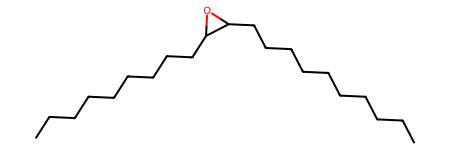

Prediction 0: CCCCC=CCC1OC1CC=CCCCCCCCCC, similarity: 0.4125874125874126

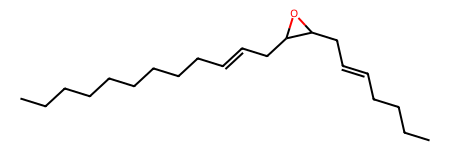

Prediction 1: CCCCCC=CC1OC1CC=CCCCCCCCCC, similarity: 0.30994152046783624

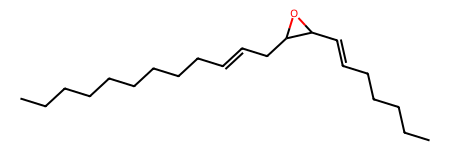

Prediction 2: CCCCCC=CCC=CCC(O)CCCCCCCCC, similarity: 0.3458646616541353

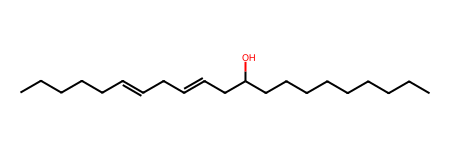

Prediction 3: CCCCCC=CCC=CCC1OC1CCCCCCCC, similarity: 0.5228758169934641

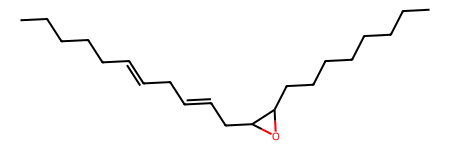

Prediction 4: CCCCCC=CCC=CCCC(=O)CCCCCCCC, similarity: 0.11038961038961038

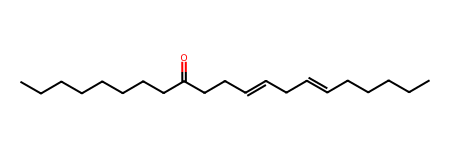

In [158]:
pairs_to_viz = list(zip(labels, sorted_predictions))[142]  # TODO: change this to visualize different pairs
best_n_to_viz = 5                                         # TODO: change this to visualize more/less predictions

if isinstance(pairs_to_viz, tuple):
    pairs_to_viz = [pairs_to_viz]

for gt_smiles, preds in pairs_to_viz:
    print("\n##################")
    print("GT smiles:", gt_smiles)
    gt_mol = Chem.MolFromSmiles(gt_smiles)
    display(gt_mol)
    for i, pred_smiles in enumerate(preds[:best_n_to_viz]):
        pred_mol = Chem.MolFromSmiles(pred_smiles)
        print(f"Prediction {i}: {pred_smiles}, similarity: {DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(gt_mol), Chem.RDKFingerprint(pred_mol))}")
        display(pred_mol)

## Analyze performance compared to DB search
Here we briefly analyze the performance of the DB baseline compared to the best predictions of our model (the similsort mode).If you want to see only the compounds overlapping between the MACE dataset and the reference library, set `ONLY_OVERLAP` to `True`. 

In [204]:
from  utils.data_utils import filter_datapoints
from metrics import compute_fp_simils 

overlap # defined during DB sarch evaluation
sorted_predictions # defined during visualization
nist_train_jsonl_path = "../data/nist/train.jsonl"
mace_jsonl_precomputed_path = "../data/mace/MACE_r05_with_db_index.jsonl"

df_reference = pd.read_json(nist_train_jsonl_path, lines=True, orient="records")
df_labels = pd.read_json(mace_jsonl_precomputed_path, lines=True, orient="records")

# filter labels as in the generation process
labels_mask = df_labels.apply(lambda row: filter_datapoints(row, preprocess_args={"max_num_peaks": 300, 
                                                                                  "max_mz":500, 
                                                                                  "max_mol_repr_len": 100, 
                                                                                  "mol_repr": "smiles"}), axis=1)

df_labels_filtered = df_labels[labels_mask]

In [206]:
# prepare all the SMILES and similarities
ONLY_OVERLAP = True

def find_best_prediction(predictions, gt_smiles):
    simils = compute_fp_simils(predictions, [gt_smiles]*len(predictions))
    max_simil = max(simils)
    best_prediction = predictions[simils.index(max_simil)]
    return best_prediction, max_simil

df_labels_filtered["predictions"] = sorted_predictions


overlapped_mask = df_labels_filtered["smiles"].isin(overlap)
df_labels_filtered_overlapped = df_labels_filtered[overlapped_mask] if ONLY_OVERLAP else df_labels_filtered

df_labels_filtered_overlapped = df_labels_filtered_overlapped.join(df_reference, on="index_of_closest", rsuffix="_ref", how="inner")

df_labels_filtered_overlapped['best_prediction'], df_labels_filtered_overlapped['best_prediction_simil'] =  zip(*df_labels_filtered_overlapped.apply(lambda row: find_best_prediction(row["predictions"], row["smiles_ref"]), axis=1))

/tmp/ipykernel_1284697/860589938.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_filtered["predictions"] = sorted_predictions


##################

Example id: 0

GT smiles: CCCCCCCCCCCCCCOC(O)C(C)CC(C)CCCCCCCCCCCCC

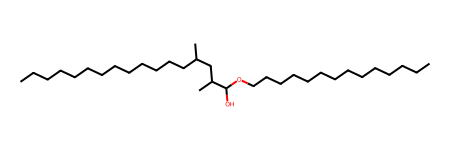

Best DB search candidate: CCCCCCCCCCCCCCCCO[Si](C)(C)CCl similarity: 0.275

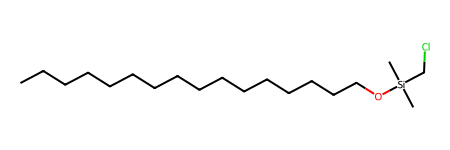

Best prediction: CCCCCCCCCCCCCCCCCCO[Si](C)(C)CCCCCCCCCCCC, similarity: 0.41935483870967744

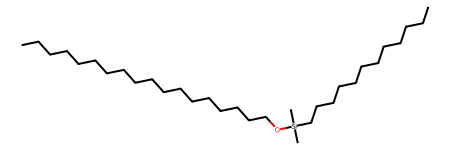

##################

Example id: 1

GT smiles: CCCCCCCCCCCCCCOC(O)C(C)CC(C)CCCCCCCCCCCCC

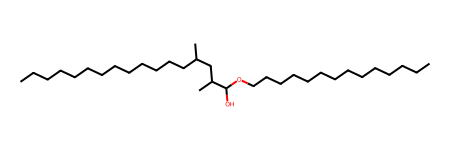

Best DB search candidate: CCCCCCCCCCCCCCO[Si](CC)(CC)CC similarity: 0.29729729729729704

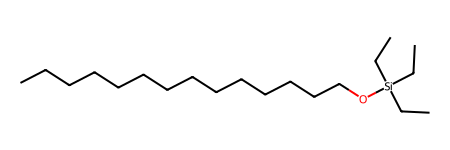

Best prediction: CCCCCCCCCCCCCCCCCCOCCCCCCCCCCCCCCC, similarity: 0.19858156028368795

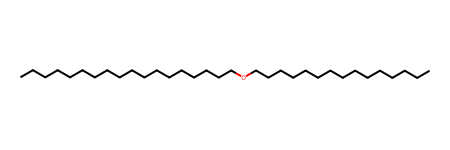

##################

Example id: 2

GT smiles: CCCCCCCCCCCCCC(C)CC(C)C(O)OC

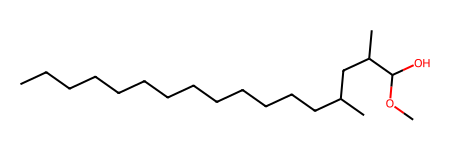

Best DB search candidate: CCCCCCCCCCC(C)CC(C)C(=O)OC similarity: 0.527777777777777

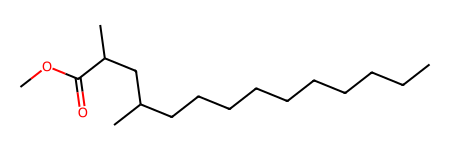

Best prediction: CCCCCCCCCCCCC(C)CC(C)C(=O)OC, similarity: 1.0

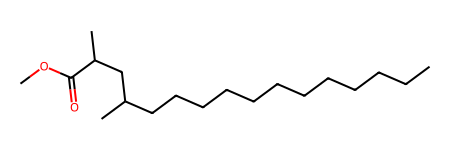

##################

Example id: 3

GT smiles: CCCCCCCCCCCCCC(C)CC(C)C(O)OC

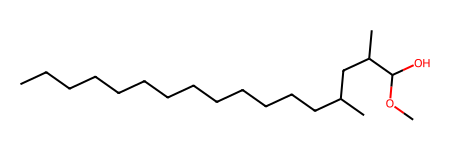

Best DB search candidate: CCCCCCCCCCC(C)CC(C)C(=O)OC similarity: 0.527777777777777

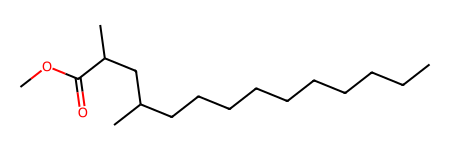

Best prediction: CCCC(C)CCCCCCCCCC(C)CC(C)C(=O)OC, similarity: 1.0

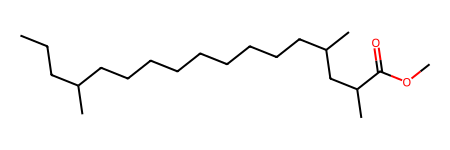

##################

Example id: 4

GT smiles: CCCCCCCCCCCCCCCCC(C)CCCC(C)CCCCCCCCCC

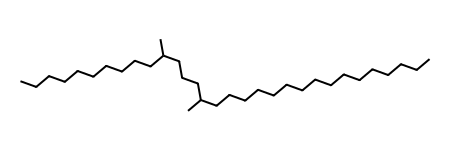

Best DB search candidate: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC similarity: 0.5

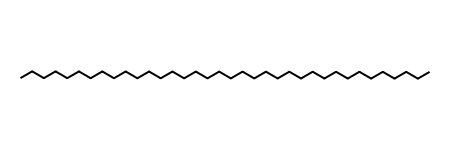

Best prediction: CCCCCCCCCCCCCCC(C)CCCC(C)CCCCCCCCCCC, similarity: 0.4666666666666667

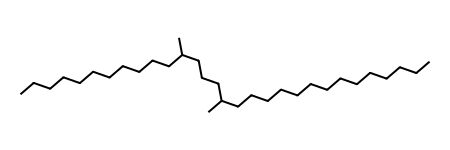

In [209]:
# visualize comparison

range_to_viz = (0, 5)

for i, row in df_labels_filtered_overlapped.iloc[min(range_to_viz):max(range_to_viz)].iterrows():
    print("\n##################")
    print(f"Example id: {i}")
    print("GT smiles:", row["smiles"])
    gt_mol = Chem.MolFromSmiles(row["smiles"])
    display(gt_mol)

    print("Best DB search candidate:", row["smiles_ref"], "similarity:", row["smiles_sim_of_closest_morgan_tanimoto"])
    db_mol = Chem.MolFromSmiles(row["smiles_ref"])
    display(db_mol)

    print(f"Best prediction: {row['best_prediction']}, similarity: {row['best_prediction_simil']}")
    pred_mol = Chem.MolFromSmiles(row["best_prediction"])
    display(pred_mol)
